**Generowanie i analiza danych - pierwszy notebook! (link: https://github.com/jakubtwalczak/Polish-people-basic-physical-attributes/blob/main/Polish_people_physical_attributes.ipynb)**

W tym notatniku, wykorzystując stworzony przeze mnie zbiór danych dot. przeciętnego wzrostu, wagi i BMI Polaków, zastosuję techniki blendingu i stackingu celem sprawdzenia ich wydajności i dokładności w warunkach tradycyjnych zadań uczenia nadzorowanego. Pierwsza część notebooka zawierać będzie klasyfikację ze względu na płeć, druga - regresję wzrostu, przy czym będzie ona podzielona na dwa segmenty (1. przewidywanie przy użyciu cech ciągłych, 2. przewidywanie z użyciem jednej cechy ciągłej i dziewięciu kategorycznych).

# Przygotowania - import bibliotek, wczytanie zbioru danych.



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier, RandomForestClassifier, StackingRegressor
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import LinearSVR
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings

warnings.filterwarnings("ignore")

In [2]:
def load_dataset(filename, index_col=None):
    dataset = pd.read_csv(f'{filename}', index_col=index_col)
    pd.options.display.max_columns = None
    return dataset

url = 'https://raw.githubusercontent.com/jakubtwalczak/Polish-people-basic-physical-attributes/main/Polish_height_weight_bmi.csv'

df = load_dataset(filename=url)
df

,Height,BMI,Sex,Weight
0,173.0,29.70,Male,88.9
1,175.8,34.24,Male,105.8
2,174.1,27.57,Male,83.6
3,179.9,25.90,Male,83.8
4,184.6,26.72,Male,91.1
...,...,...,...,...
9995,176.0,22.38,Female,69.3
9996,169.0,27.36,Female,78.1
9997,155.7,25.05,Female,60.7
9998,181.3,24.38,Female,80.1


# Klasyfikacja.

## Podział na predyktory i etykiety.

Do klasyfikacji użyte zostaną dwie cechy - wzrost i waga. BMI zostanie pominięte, bo przy zestawieniu z dwiema pozostałymi cechami nie wnosi dodatkowej wartości dla predykcji, a ponadto dzięki ograniczeniu do dwóch cech zyskamy dodatkową wartość dla wizualizacji klasyfikacji.

In [3]:
X_clas = df.drop(columns=['Sex', 'BMI'])
y_clas = df['Sex']

In [4]:
X_clas

,Height,Weight
0,173.0,88.9
1,175.8,105.8
2,174.1,83.6
3,179.9,83.8
4,184.6,91.1
...,...,...
9995,176.0,69.3
9996,169.0,78.1
9997,155.7,60.7
9998,181.3,80.1


In [5]:
y_clas

0         Male
1         Male
2         Male
3         Male
4         Male
         ...  
9995    Female
9996    Female
9997    Female
9998    Female
9999    Female
Name: Sex, Length: 10000, dtype: object

## Kodowanie etykiet.

In [6]:
le = LabelEncoder()
y_clas = le.fit_transform(y_clas)
y_clas

array([1, 1, 1, ..., 0, 0, 0])

## Podział na dane treningowe i testowe.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_clas, y_clas, test_size=0.2, random_state=100, stratify=y_clas)

## Model blendingowy.

Konwencją przy modelowaniu w każdym segmencie jest to, że najpierw zastowany zostanie blending, następnie stacking, a na końcu pojedynczy model. Dodatkowo mierzony będzie czas, jaki poszczególne modele potrzebują dla treningu i predykcji. W trakcie treningu modelu blendingowego dla każdego osobnego algorytmu dobierane będą hiperparametry, które będą wykorzystywane w dalszej części segmentu dla kolejnych modeli.

In [8]:
%%time

base_models = [
    ('Random Forest', RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
    ('Decision Tree Classifier', DecisionTreeClassifier(), {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}),
    ('AdaBoost Classifier', AdaBoostClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}),
    ('Logistic Regression', make_pipeline(RobustScaler(), PolynomialFeatures(), LogisticRegression()),
     {'logisticregression__C': [0.1, 1, 10], 'logisticregression__penalty': ['l1', 'l2'],
      'polynomialfeatures__degree': [1, 2, 3]}),
]

meta_model = XGBClassifier()

predictions_train = []
predictions_test = []

for name, model, params in base_models:
    if name == 'Logistic Regression':
        poly_model = make_pipeline(RobustScaler(), PolynomialFeatures(), LogisticRegression())
        grid_search = GridSearchCV(poly_model, params, cv=3, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)

        print(f'{name} (Polynomial Degree {grid_search.best_params_["polynomialfeatures__degree"]}) - Best Parameters: {grid_search.best_params_}')
        print(f'{name} training accuracy: {accuracy_score(y_train, train_pred)}')
        print(f'{name} test accuracy: {accuracy_score(y_test, test_pred)}')
        print('_____________________________________________________\n')

        predictions_train.append(train_pred.reshape(-1, 1))
        predictions_test.append(test_pred.reshape(-1, 1))
    else:
        grid_search = GridSearchCV(model, params, cv=3, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)

        print(f'{name} - Best Parameters: {grid_search.best_params_}')
        print(f'{name} training accuracy: {accuracy_score(y_train, train_pred)}')
        print(f'{name} test accuracy: {accuracy_score(y_test, test_pred)}')
        print('_____________________________________________________\n')

        predictions_train.append(train_pred.reshape(-1, 1))
        predictions_test.append(test_pred.reshape(-1, 1))

predictions_train = np.hstack(predictions_train)
predictions_test = np.hstack(predictions_test)
meta_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 9], 'learning_rate': [0.01, 0.1, 0.2]}
meta_model.fit(predictions_train, y_train)

meta_model_grid_search = GridSearchCV(meta_model, meta_params, cv=3, scoring='accuracy')
meta_model_grid_search.fit(predictions_train, y_train)

best_meta_model = meta_model_grid_search.best_estimator_
blending_predictions = best_meta_model.predict(predictions_test)

print(f'Meta Model (XGBClassifier) - Best Parameters: {meta_model_grid_search.best_params_}')
print(f'Blending model accuracy: {accuracy_score(y_test, blending_predictions)}')

Random Forest - Best Parameters: {'max_depth': 10, 'n_estimators': 50}
Random Forest training accuracy: 0.9135
Random Forest test accuracy: 0.8745
_____________________________________________________

Decision Tree Classifier - Best Parameters: {'max_depth': 10, 'min_samples_split': 10}
Decision Tree Classifier training accuracy: 0.896
Decision Tree Classifier test accuracy: 0.8555
_____________________________________________________

AdaBoost Classifier - Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
AdaBoost Classifier training accuracy: 0.869875
AdaBoost Classifier test accuracy: 0.8725
_____________________________________________________

Logistic Regression (Polynomial Degree 3) - Best Parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'polynomialfeatures__degree': 3}
Logistic Regression training accuracy: 0.8675
Logistic Regression test accuracy: 0.875
_____________________________________________________

Meta Model (XGBClassifier) -

Tworzymy macierz pomyłek.

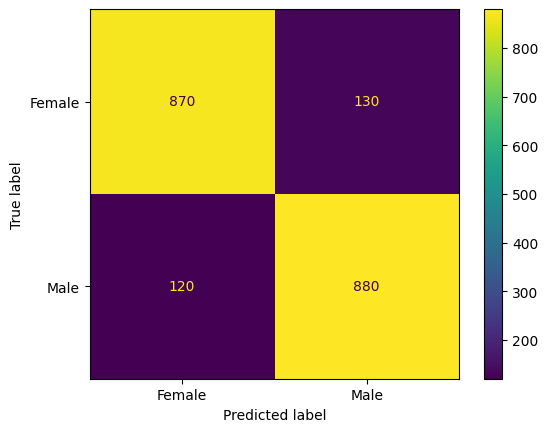

In [9]:
cm = confusion_matrix(y_test, blending_predictions)
ConfusionMatrixDisplay(cm, display_labels=['Female', 'Male']).plot()

Sprawdzamy również, predykcje którego sub-modelu miały największą wartość dla modelu wyjściowego - w tym wypadku aż 97,5% istotności przypada na las losowy.

In [10]:
best_meta_model.feature_importances_

array([0.95512635, 0.02764194, 0.014512  , 0.00271972], dtype=float32)

## Model stackingowy.

Dla tego modelu dobieramy te same algorytmy klasyfikujące, jednak z wyszukanymi wcześniej przez GridSearch parametrami.

In [11]:
%%time

base_models = [
    ('Random Forest', RandomForestClassifier(max_depth=10, n_estimators=50)),
    ('Decision Tree Classifier', DecisionTreeClassifier(max_depth=10, min_samples_split=10)),
    ('AdaBoost Classifier', AdaBoostClassifier(learning_rate=0.1, n_estimators=50)),
    ('Logistic Regression', make_pipeline(RobustScaler(), PolynomialFeatures(degree=3), LogisticRegression(C=0.1, penalty='l2'))),
]

meta_model_clas = XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=200)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model_clas)
stacking_model.fit(X_train, y_train)
stacking_predictions = stacking_model.predict(X_test)
accuracy = stacking_model.score(X_test, y_test)
print(f"Stacking model accuracy: {accuracy}")

Stacking model accuracy: 0.8725
CPU times: user 6.34 s, sys: 500 ms, total: 6.84 s
Wall time: 10.3 s


Minimalnie spada dokładność, co wynika z dość wyraźnego wzrostu błędnych przypisań dla mężczyzn, którego nie kompensuje w całości poprawa przewidywań dla kobiet.

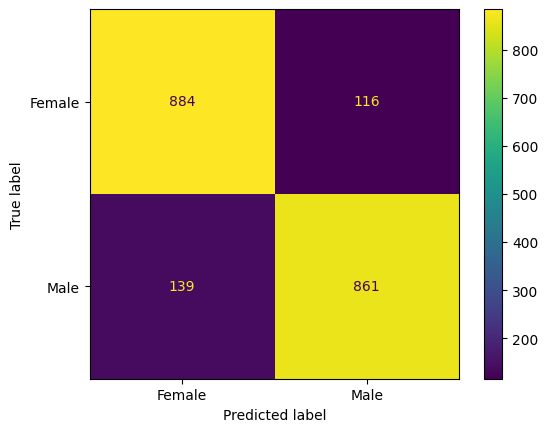

In [12]:
cm2 = confusion_matrix(y_test, stacking_predictions)
ConfusionMatrixDisplay(cm2, display_labels=['Female', 'Male']).plot()

W tym wypadku mamy możliwość sprawdzenia, jak przebiega granica oddzielająca od siebie klasy wśród obu predyktorów. Widać, że przebiega ona mniej więcej między 170-180 cm wzrostu. Granica jest niemal pionowa, a więc wzrost jest dla klasyfikatora ważniejszy niż waga.

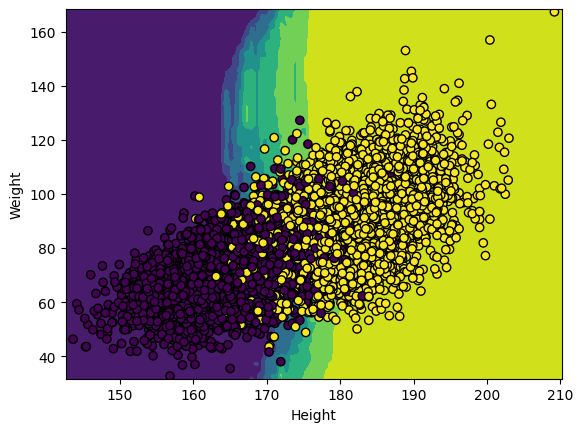

In [13]:
disp_stack = DecisionBoundaryDisplay.from_estimator(stacking_model, X_train)
disp_stack.ax_.scatter(X_train['Height'], X_train['Weight'], c=y_train,
                  edgecolor="k")

## Pojedynczy model - algorytm wyjściowy w modelach blendingowym i stackingowym.

Trenujemy tym razem wyłącznie model wyjściowy w klasyfikatorze stackingowym.

In [14]:
%%time

meta_model_clas.fit(X_train, y_train)
single_predictions_clas = meta_model_clas.predict(X_test)
print(f'Single model accuracy: {accuracy_score(y_test, single_predictions_clas)}')

Single model accuracy: 0.873
CPU times: user 410 ms, sys: 5.98 ms, total: 416 ms
Wall time: 351 ms


Wyniki są podobne, model uczył się szybko, choć na jego odpowiednie dopasowanie pozwoliły wcześniejsze treningi.

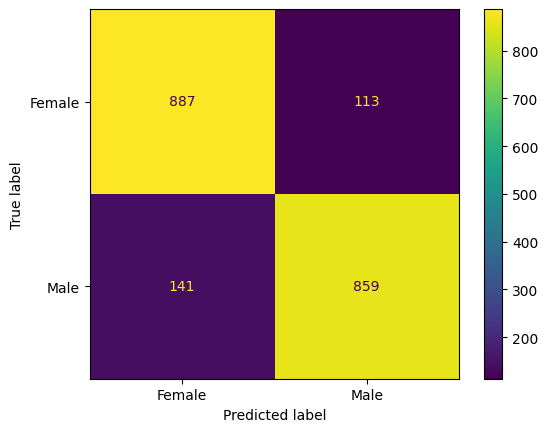

In [15]:
cm3 = confusion_matrix(y_test, single_predictions_clas)
ConfusionMatrixDisplay(cm3, display_labels=['Female', 'Male']).plot()

Pod względem istotności waga pełni jedynie rolę uzupełniającą. Granica między klasami jest w tym wypadku bardziej płynna.

In [16]:
print(f"Features' names: {meta_model_clas.feature_names_in_}")
print(f"Features' importances: {meta_model_clas.feature_importances_}")

Features' names: ['Height' 'Weight']
Features' importances: [0.94702876 0.05297127]


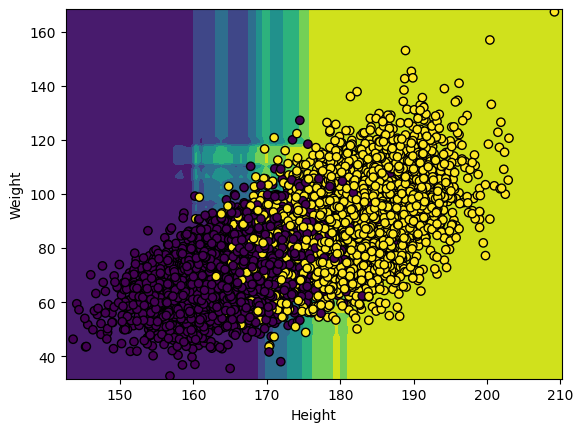

In [17]:
disp_single = DecisionBoundaryDisplay.from_estimator(meta_model_clas, X_train)
disp_single.ax_.scatter(X_train['Height'], X_train['Weight'], c=y_train,
                  edgecolor="k")

# Regresja.

## Regresja przy użyciu zmiennych ciągłych.

### Podział na zmienne niezależne i zmienną zależną, usunięcie zbędnych zmiennych.

Do przewidywania wzrostu BMI tym razem przyda się znacznie bardziej niż do klasyfikacji, umożliwi ona dokładne predykcje. Do tego modelu nie wykorzystujemy cechy odnoszącej się do płci.

In [18]:
X_reg = df.drop(columns=['Height', 'Sex'])
y_reg = df[['Height']].values

In [19]:
X_reg

,BMI,Weight
0,29.70,88.9
1,34.24,105.8
2,27.57,83.6
3,25.90,83.8
4,26.72,91.1
...,...,...
9995,22.38,69.3
9996,27.36,78.1
9997,25.05,60.7
9998,24.38,80.1


In [20]:
y_reg

array([[173. ],
       [175.8],
       [174.1],
       ...,
       [155.7],
       [181.3],
       [172.6]])

### Skalowanie danych, podział zbiorów.

In [21]:
scaler_x = RobustScaler()
X_reg_sc = scaler_x.fit_transform(X_reg)

In [22]:
scaler_y = RobustScaler()

y_reg_sc = scaler_y.fit_transform(y_reg)
y_reg_sc

array([[-0.00653595],
       [ 0.17647059],
       [ 0.06535948],
       ...,
       [-1.1372549 ],
       [ 0.53594771],
       [-0.03267974]])

In [23]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg_sc, y_reg_sc, test_size=0.2, random_state=1)

### Model blendingowy.

Metryki wskazują na bardzo wysoki stopień generalizacji przez model.

In [24]:
%%time

base_models_reg = [
    ('Ridge', Ridge(), {'alpha': [0.1, 1, 10], 'solver': ['auto', 'svd', 'sag', 'saga']}),
    ('Lasso', Lasso(), {'alpha': [0.1, 1, 10], 'max_iter': [500, 1000], 'tol': [0.001, 0.01, 0.1]}),
    ('K-Neighbors Regressor', KNeighborsRegressor(), {'n_neighbors': [5, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree']}),
    ('Linear Regression', make_pipeline(PolynomialFeatures(), LinearRegression()), {'linearregression__fit_intercept': [True, False],
                                                                                    'linearregression__positive': [True, False],
                                                                                    'polynomialfeatures__degree': [1,2,3]})
]

meta_model_reg = LinearSVR()

predictions_train = []
predictions_test = []

for name, model, params in base_models_reg:
    if name == 'Linear Regression':
        poly_model = make_pipeline(PolynomialFeatures(), LinearRegression())
        grid_search = GridSearchCV(poly_model, params, cv=3)
        grid_search.fit(X_train_reg, y_train_reg)

        best_model = grid_search.best_estimator_

        train_pred = best_model.predict(X_train_reg)
        test_pred = best_model.predict(X_test_reg)

        print(f'{name} (Polynomial Degree {grid_search.best_params_["polynomialfeatures__degree"]}) - Best Parameters: {grid_search.best_params_}')
        print(f'{name} training MAE: {mean_absolute_error(y_train_reg, train_pred)}')
        print(f'{name} test MAE: {mean_absolute_error(y_test_reg, test_pred)}')
        print('_____________________________________________________\n')

        predictions_train.append(train_pred.reshape(-1, 1))
        predictions_test.append(test_pred.reshape(-1, 1))
    else:
        grid_search = GridSearchCV(model, params, cv=3)
        grid_search.fit(X_train_reg, y_train_reg)

        best_model = grid_search.best_estimator_

        train_pred = best_model.predict(X_train_reg)
        test_pred = best_model.predict(X_test_reg)

        print(f'{name} - Best Parameters: {grid_search.best_params_}')
        print(f'{name} training MAE: {mean_absolute_error(y_train_reg, train_pred)}')
        print(f'{name} test MAE: {mean_absolute_error(y_test_reg, test_pred)}')
        print('_____________________________________________________\n')

        predictions_train.append(train_pred.reshape(-1, 1))
        predictions_test.append(test_pred.reshape(-1, 1))

predictions_train = np.hstack(predictions_train)
predictions_test = np.hstack(predictions_test)
meta_params = {
    'C': [0.1, 1, 10],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'epsilon': [0.01, 0.1, 0.2]
}
meta_model_reg.fit(predictions_train, y_train_reg)

meta_model_grid_search = GridSearchCV(meta_model_reg, meta_params, cv=3)
meta_model_grid_search.fit(predictions_train, y_train_reg)

best_meta_model = meta_model_grid_search.best_estimator_
blending_predictions = best_meta_model.predict(predictions_test)

print(f'Meta Model (LinearSVR) - Best Parameters: {meta_model_grid_search.best_params_}')
print(f'Meta Model (LinearSVR) - R2 Score: {r2_score(y_test_reg, blending_predictions)}')
print(f'Meta Model (LinearSVR) - MAE: {mean_absolute_error(y_test_reg, blending_predictions)}')
print(f'Meta Model (LinearSVR) - MSE: {mean_squared_error(y_test_reg, blending_predictions)}')

Ridge - Best Parameters: {'alpha': 0.1, 'solver': 'sag'}
Ridge training MAE: 0.06722586274927309
Ridge test MAE: 0.07011565717524582
_____________________________________________________

Lasso - Best Parameters: {'alpha': 0.1, 'max_iter': 500, 'tol': 0.001}
Lasso training MAE: 0.3605556772618819
Lasso test MAE: 0.362840155978093
_____________________________________________________

K-Neighbors Regressor - Best Parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}
K-Neighbors Regressor training MAE: 1.1437908496732083e-05
K-Neighbors Regressor test MAE: 0.012996596969855877
_____________________________________________________

Linear Regression (Polynomial Degree 3) - Best Parameters: {'linearregression__fit_intercept': True, 'linearregression__positive': False, 'polynomialfeatures__degree': 3}
Linear Regression training MAE: 0.0035581977115418154
Linear Regression test MAE: 0.003690767264979944
_____________________________________________________

Meta Mod

Sprawdzamy współczynniki regresji (którymi są de facto predykcje submodeli) i wyraz wolny funkcji opisującej regresję.

In [25]:
print(f'Regression coefficients: {best_meta_model.coef_}')
print(f'Constant term: {best_meta_model.intercept_}')

Regression coefficients: [-0.02088944  0.00171041  0.75742179  0.26481036]
Constant term: [-0.001283]


### Model stackingowy.

Ponownie stosujemy te same hiperparametry dla poszczególnych algorytmów składowych. Predykcje są nawet jeszcze bardziej dokładne.

In [26]:
%%time

base_models_reg = [
    ('Ridge', Ridge(alpha=0.1, solver='sag')),
    ('Lasso', Lasso(alpha=0.1, max_iter=500, tol=0.001)),
    ('K-Neighbors Regressor', KNeighborsRegressor(n_neighbors=5, algorithm='ball_tree', weights='distance')),
    ('Linear Regression', make_pipeline(PolynomialFeatures(degree=3), LinearRegression(fit_intercept=True, positive=False)))
]

meta_model_reg = LinearSVR(C=1, epsilon= 0.01, loss='epsilon_insensitive')

stacking_model = StackingRegressor(estimators=base_models_reg, final_estimator=meta_model_reg)
stacking_model.fit(X_train_reg, y_train_reg)
stacking_predictions = stacking_model.predict(X_test_reg)
print(f'Stacking model - R2 Score: {r2_score(y_test_reg, stacking_predictions)}')
print(f'Stacking model - MAE: {mean_absolute_error(y_test_reg, stacking_predictions)}')
print(f'Stacking model - MSE: {mean_squared_error(y_test_reg, stacking_predictions)}')

Stacking model - R2 Score: 0.9998811721975248
Stacking model - MAE: 0.004872042144429187
Stacking model - MSE: 5.3070362581417315e-05
CPU times: user 936 ms, sys: 291 ms, total: 1.23 s
Wall time: 1.08 s


### Pojedynczy model.

Najmniej precyzyjny jest model singularny - wyjściowy w StackingRegressorze.

In [27]:
%%time

meta_model_reg.fit(X_train_reg, y_train_reg)
single_predictions = meta_model_reg.predict(X_test_reg)
print(f'Single Model (LinearSVR) - R2 Score: {r2_score(y_test_reg, single_predictions)}')
print(f'Single Model (LinearSVR) - MAE: {mean_absolute_error(y_test_reg, single_predictions)}')
print(f'Single Model (LinearSVR) - MSE: {mean_squared_error(y_test_reg, single_predictions)}')

Single Model (LinearSVR) - R2 Score: 0.9753769090619764
Single Model (LinearSVR) - MAE: 0.06852873866436049
Single Model (LinearSVR) - MSE: 0.010997059078230764
CPU times: user 150 ms, sys: 937 µs, total: 151 ms
Wall time: 210 ms


Tym razem współczynniki faktycznie odnoszą się do cech.

In [28]:
print(f'Regression coefficients: {meta_model_reg.coef_}')
print(f'Constant term: {meta_model_reg.intercept_}')

Regression coefficients: [-1.05475866  1.50292997]
Constant term: [-0.06830244]


### Wykres 3D - ground truth kontra predykcje.

Wykres oddaje, że predykcje zasadniczo tym bardziej pokrywają się z prawdą, im bliżej środka rozkładu. Dla wartości, które odstają od centrum, spore pomyłki notuje model pojedynczy.

In [29]:
X_test_inv = scaler_x.inverse_transform(X_test_reg)
y_test_inv = scaler_y.inverse_transform(y_test_reg)
bmi, weight = X_test_inv[:,0], X_test_inv[:,1]

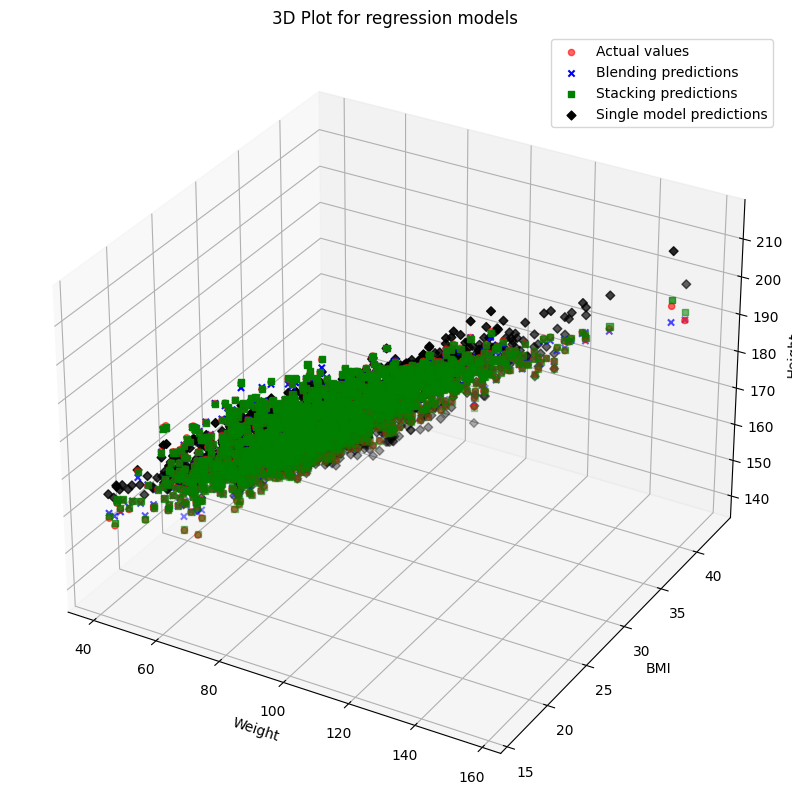

In [30]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(weight, bmi, y_test_inv, c='r', marker='o', label='Actual values', alpha=0.6)
ax.scatter(weight, bmi, scaler_y.inverse_transform(blending_predictions.reshape(-1,1)), c='b', marker='x', label='Blending predictions')
ax.scatter(weight, bmi, scaler_y.inverse_transform(stacking_predictions.reshape(-1,1)), c='g', marker='s', label='Stacking predictions')
ax.scatter(weight, bmi, scaler_y.inverse_transform(single_predictions.reshape(-1,1)), c='k', marker='D', label='Single model predictions')

ax.set_xlabel('Weight')
ax.set_ylabel('BMI')
ax.set_zlabel('Height')
ax.set_title('3D Plot for regression models')

ax.legend()
plt.show()

## Regresja przy użyciu cech kategorialnych.

### Przygotowanie zbioru danych, stworzenie cech kategorialnych.

W tym segmencie nieco utrudnimy pracę naszym regresorom, tworząc cechy kategorialne. Najpierw kopiujemy nasz oryginalny zbiór danych.

In [31]:
df_encoded = df.copy()
df_encoded

,Height,BMI,Sex,Weight
0,173.0,29.70,Male,88.9
1,175.8,34.24,Male,105.8
2,174.1,27.57,Male,83.6
3,179.9,25.90,Male,83.8
4,184.6,26.72,Male,91.1
...,...,...,...,...
9995,176.0,22.38,Female,69.3
9996,169.0,27.36,Female,78.1
9997,155.7,25.05,Female,60.7
9998,181.3,24.38,Female,80.1


Zamiast ciągłego BMI będziemy stosować kategorie, które faktycznie są odzwierciedleniem faktycznych kategorii stosowanych do opisania tego współczynnika. Te kategorie oraz płeć przekształcimy na odrębne cechy kategoryczne.

In [32]:
bins = [0, 16.5, 18.5, 25, 30, 35, 40, 50]
df_encoded['BMI_Class'] = pd.cut(df['BMI'], bins=bins,
                         labels=['Severely_underweight', 'Underweight', 'Normal', 'Overweight', 'Obesity class I', 'Obesity class II', 'Obesity class III'])
df_encoded = pd.get_dummies(data=df_encoded, columns=['Sex', 'BMI_Class'], prefix_sep='_Is_')
df_encoded

,Height,BMI,Weight,Sex_Is_Female,Sex_Is_Male,BMI_Class_Is_Severely_underweight,BMI_Class_Is_Underweight,BMI_Class_Is_Normal,BMI_Class_Is_Overweight,BMI_Class_Is_Obesity class I,BMI_Class_Is_Obesity class II,BMI_Class_Is_Obesity class III
0,173.0,29.70,88.9,0,1,0,0,0,1,0,0,0
1,175.8,34.24,105.8,0,1,0,0,0,0,1,0,0
2,174.1,27.57,83.6,0,1,0,0,0,1,0,0,0
3,179.9,25.90,83.8,0,1,0,0,0,1,0,0,0
4,184.6,26.72,91.1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,176.0,22.38,69.3,1,0,0,0,1,0,0,0,0
9996,169.0,27.36,78.1,1,0,0,0,0,1,0,0,0
9997,155.7,25.05,60.7,1,0,0,0,0,1,0,0,0
9998,181.3,24.38,80.1,1,0,0,0,1,0,0,0,0


In [33]:
X_reg = df_encoded.drop(columns=['Height', 'BMI'])
y_reg = df_encoded[['Height']].values

### Skalowanie i podział zbiorów.

In [34]:
scaler_x = RobustScaler()
X_reg['Weight'] = scaler_x.fit_transform(X_reg[['Weight']])
X_reg

,Weight,Sex_Is_Female,Sex_Is_Male,BMI_Class_Is_Severely_underweight,BMI_Class_Is_Underweight,BMI_Class_Is_Normal,BMI_Class_Is_Overweight,BMI_Class_Is_Obesity class I,BMI_Class_Is_Obesity class II,BMI_Class_Is_Obesity class III
0,0.440367,0,1,0,0,0,1,0,0,0
1,1.215596,0,1,0,0,0,0,1,0,0
2,0.197248,0,1,0,0,0,1,0,0,0
3,0.206422,0,1,0,0,0,1,0,0,0
4,0.541284,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,-0.458716,1,0,0,0,1,0,0,0,0
9996,-0.055046,1,0,0,0,0,1,0,0,0
9997,-0.853211,1,0,0,0,0,1,0,0,0
9998,0.036697,1,0,0,0,1,0,0,0,0


In [35]:
scaler_y = RobustScaler()
y_reg = scaler_y.fit_transform(y_reg)
y_reg

array([[-0.00653595],
       [ 0.17647059],
       [ 0.06535948],
       ...,
       [-1.1372549 ],
       [ 0.53594771],
       [-0.03267974]])

In [36]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=1)

### Model blendingowy.

Wyraźnie widać, jak metryki się pogarszają ze względu na dobór cech: współczynnik determinacji spada, śr. błąd bezwzględny i śr. błąd kwadratowy rosną. Nadal są to jednak stosunkowo dobre wartości, jak na tak mało dokładne wskazania predyktorów.

In [37]:
%%time

base_models_reg = [
    ('Ridge', Ridge(), {'alpha': [0.1, 1, 10], 'solver': ['auto', 'svd', 'sag', 'saga']}),
    ('Lasso', Lasso(), {'alpha': [0.1, 1, 10], 'max_iter': [500, 1000], 'tol': [0.001, 0.01, 0.1]}),
    ('K-Neighbors Regressor', KNeighborsRegressor(), {'n_neighbors': [5, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree']}),
    ('Linear Regression', make_pipeline(PolynomialFeatures(), LinearRegression()), {'linearregression__fit_intercept': [True, False],
                                                                                    'linearregression__positive': [True, False],
                                                                                    'polynomialfeatures__degree': [1,2,3]})
]

meta_model_reg = LinearSVR()

predictions_train = []
predictions_test = []

for name, model, params in base_models_reg:
    if name == 'Linear Regression':
        poly_model = make_pipeline(PolynomialFeatures(), LinearRegression())
        grid_search = GridSearchCV(poly_model, params, cv=3)
        grid_search.fit(X_train_reg, y_train_reg)

        best_model = grid_search.best_estimator_

        train_pred = best_model.predict(X_train_reg)
        test_pred = best_model.predict(X_test_reg)

        print(f'{name} (Polynomial Degree {grid_search.best_params_["polynomialfeatures__degree"]}) - Best Parameters: {grid_search.best_params_}')
        print(f'{name} training MAE: {mean_absolute_error(y_train_reg, train_pred)}')
        print(f'{name} test MAE: {mean_absolute_error(y_test_reg, test_pred)}')
        print('_____________________________________________________\n')

        predictions_train.append(train_pred.reshape(-1, 1))
        predictions_test.append(test_pred.reshape(-1, 1))
    else:
        grid_search = GridSearchCV(model, params, cv=3)
        grid_search.fit(X_train_reg, y_train_reg)

        best_model = grid_search.best_estimator_

        train_pred = best_model.predict(X_train_reg)
        test_pred = best_model.predict(X_test_reg)

        print(f'{name} - Best Parameters: {grid_search.best_params_}')
        print(f'{name} training MAE: {mean_absolute_error(y_train_reg, train_pred)}')
        print(f'{name} test MAE: {mean_absolute_error(y_test_reg, test_pred)}')
        print('_____________________________________________________\n')

        predictions_train.append(train_pred.reshape(-1, 1))
        predictions_test.append(test_pred.reshape(-1, 1))

predictions_train = np.hstack(predictions_train)
predictions_test = np.hstack(predictions_test)
meta_params = {
    'C': [0.1, 1, 10],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'epsilon': [0.01, 0.1, 0.2]
}
meta_model_reg.fit(predictions_train, y_train_reg)

meta_model_grid_search = GridSearchCV(meta_model_reg, meta_params, cv=3)
meta_model_grid_search.fit(predictions_train, y_train_reg)

best_meta_model = meta_model_grid_search.best_estimator_
blending_predictions = best_meta_model.predict(predictions_test)

print(f'Meta Model (LinearSVR) - Best Parameters: {meta_model_grid_search.best_params_}')
print(f'Meta Model (LinearSVR) - R2 Score: {r2_score(y_test_reg, blending_predictions)}')
print(f'Meta Model (LinearSVR) - MAE: {mean_absolute_error(y_test_reg, blending_predictions)}')
print(f'Meta Model (LinearSVR) - MSE: {mean_squared_error(y_test_reg, blending_predictions)}')

Ridge - Best Parameters: {'alpha': 0.1, 'solver': 'sag'}
Ridge training MAE: 0.20882599802333335
Ridge test MAE: 0.2166071859117384
_____________________________________________________

Lasso - Best Parameters: {'alpha': 0.1, 'max_iter': 500, 'tol': 0.1}
Lasso training MAE: 0.34937505784343764
Lasso test MAE: 0.35409385409770266
_____________________________________________________

K-Neighbors Regressor - Best Parameters: {'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'uniform'}
K-Neighbors Regressor training MAE: 0.19573779956427
K-Neighbors Regressor test MAE: 0.2129753812636164
_____________________________________________________

Linear Regression (Polynomial Degree 2) - Best Parameters: {'linearregression__fit_intercept': True, 'linearregression__positive': True, 'polynomialfeatures__degree': 2}
Linear Regression training MAE: 0.20446153987311055
Linear Regression test MAE: 0.21139127444597616
_____________________________________________________

Meta Model (LinearSVR) - 

In [38]:
print(f'Regression coefficients: {best_meta_model.coef_}')
print(f'Constant term: {best_meta_model.intercept_}')

Regression coefficients: [-0.046964   -0.02708181  0.80653963  0.26288675]
Constant term: [1.01317602e-05]


### Model stackingowy.

Bardzo porównywalne są wyniki modelu stackingowego.

In [39]:
%%time

base_models_reg = [
    ('Ridge', Ridge(alpha=0.1, solver='sag')),
    ('Lasso', Lasso(alpha=0.1, max_iter=500, tol=0.001)),
    ('K-Neighbors Regressor', KNeighborsRegressor(n_neighbors=15, algorithm='auto', weights='uniform')),
    ('Linear Regression', make_pipeline(PolynomialFeatures(degree=2), LinearRegression(fit_intercept=True, positive=True)))
]

meta_model_reg = LinearSVR(C=1, epsilon= 0.01, loss='squared_epsilon_insensitive')

stacking_model = StackingRegressor(estimators=base_models_reg, final_estimator=meta_model_reg)
stacking_model.fit(X_train_reg, y_train_reg)
stacking_predictions = stacking_model.predict(X_test_reg)
print(f'Stacking model - R2 Score: {r2_score(y_test_reg, stacking_predictions)}')
print(f'Stacking model - MAE: {mean_absolute_error(y_test_reg, stacking_predictions)}')
print(f'Stacking model - MSE: {mean_squared_error(y_test_reg, stacking_predictions)}')

Stacking model - R2 Score: 0.8470103919164256
Stacking model - MAE: 0.21046943823463352
Stacking model - MSE: 0.0683275614213153
CPU times: user 1.2 s, sys: 819 ms, total: 2.02 s
Wall time: 1.19 s


### Model pojedynczy - LinearSVR.

Model pojedynczy notuje minimalne pogorszenie wyników przy znacznie wyższej szybkości obliczeń.

In [40]:
%%time

meta_model_reg.fit(X_train_reg, y_train_reg)
single_predictions = meta_model_reg.predict(X_test_reg)
print(f'Single Model (LinearSVR) - R2 Score: {r2_score(y_test_reg, single_predictions)}')
print(f'Single Model (LinearSVR) - MAE: {mean_absolute_error(y_test_reg, single_predictions)}')
print(f'Single Model (LinearSVR) - MSE: {mean_squared_error(y_test_reg, single_predictions)}')

Single Model (LinearSVR) - R2 Score: 0.8374010780252883
Single Model (LinearSVR) - MAE: 0.21659494793120432
Single Model (LinearSVR) - MSE: 0.07261923190363137
CPU times: user 63.2 ms, sys: 3.7 ms, total: 66.9 ms
Wall time: 62.4 ms


In [41]:
print(f'Regression coefficients: {meta_model_reg.coef_}')
print(f'Constant term: {meta_model_reg.intercept_}')

Regression coefficients: [ 0.99550297 -0.20971364  0.10982195  1.65845503  1.30071995  0.63380093
  0.01365483 -0.61366056 -1.26656059 -1.82630128]
Constant term: [-0.09989169]


# Wykresy regresji - waga, wzrost.

Wykresy obrazujące linię regresji wyrysujemy dla wagi i wzrostu dla czytelności wizualizacji.

In [42]:
sc_xreg = RobustScaler()
sc_yreg = RobustScaler()
X_stand = sc_xreg.fit_transform(df[['Weight']])
y_stand = sc_yreg.fit_transform(df[['Height']])

In [43]:
best_meta_model.fit(X_stand, y_stand)
stacking_model.fit(X_stand, y_stand)
meta_model_reg.fit(X_stand, y_stand)

LinearSVR(C=1, epsilon=0.01, loss='squared_epsilon_insensitive')

Wartości trzeba posortować, aby wykres był czytelny i estetyczny.

In [44]:
X_sorted = df[['Weight']].sort_values(by='Weight').values
X_sorted_stand = sc_xreg.transform(X_sorted)
y_blend_pred = best_meta_model.predict(X_sorted_stand)
y_stack_pred = stacking_model.predict(X_sorted_stand)
y_single_pred = meta_model_reg.predict(X_sorted_stand)

Linia regresji dla blendingu i modelu pojedynczego się pokrywają. Spora jest różnica nachylenia oraz wyższy wyraz wolny regresji modelu stackingowego.

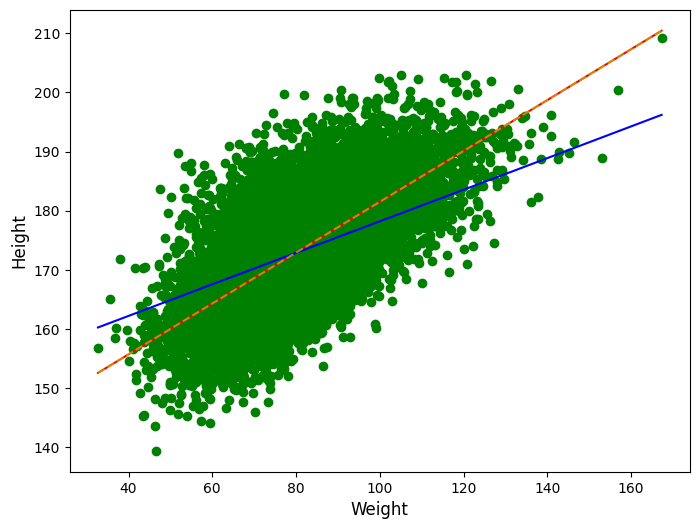

In [45]:
fig, ax = plt.subplots(figsize = (8,6))

ax.scatter(sc_xreg.inverse_transform(X_stand), sc_yreg.inverse_transform(y_stand), c='g')
ax.plot(sc_xreg.inverse_transform(X_sorted_stand), sc_yreg.inverse_transform(y_blend_pred.reshape(-1,1)), c='r')
ax.plot(sc_xreg.inverse_transform(X_sorted_stand), sc_yreg.inverse_transform(y_stack_pred.reshape(-1,1)), c='b')
ax.plot(sc_xreg.inverse_transform(X_sorted_stand), sc_yreg.inverse_transform(y_single_pred.reshape(-1,1)), c='y', linestyle='--', alpha=0.7)
plt.xlabel('Weight', fontsize=12)
plt.ylabel('Height', fontsize=12)
plt.show()